In [4]:
import os
import cv2
from natsort import natsorted
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

README not found


In [5]:
all_images = []
all_labels = []

entries = os.listdir("dataset")
# Natsort is used to sort the images in the order of their names which the normal sort fails to do
entries = natsorted(entries)
for i,entry in enumerate(entries):
    images = os.listdir("dataset/"+entry)
    images = natsorted(images)
    for image in images:
        # Reading the image and converting it to grayscale
        img = cv2.imread("dataset/"+entry+"/"+image,cv2.IMREAD_GRAYSCALE)
        # Flatten / normalize the image
        all_images.append(img.flatten()/255)
        all_labels.append(i+1)

# Generating Data matrix
all_images = np.array(all_images)
all_labels = np.array(all_labels)
all_labels=all_labels.reshape(all_labels.shape[0],-1)

print(f"Images shape: {all_images.shape}")
print(f"Labels shape: {all_labels.shape}")

Images shape: (400, 10304)
Labels shape: (400, 1)


In [6]:
# Splitting the data into train and test (70% for training and 30% images for testing)
X = all_images
Y = all_labels
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3)

print(f"Xtrain shape: {Xtrain.shape}")
print(f"Ytrain shape: {Ytrain.shape}")
print(f"Xtest shape: {Xtest.shape}")
print(f"Ytest shape: {Ytest.shape}")

Xtrain shape: (280, 10304)
Ytrain shape: (280, 1)
Xtest shape: (120, 10304)
Ytest shape: (120, 1)


In [7]:
Xtrain_transposed = Xtrain.transpose()
means = [np.mean(row) for row in Xtrain_transposed]
means = np.array(means)
print(f"Means shape: {means.shape}")

Means shape: (10304,)


In [8]:
Z = Xtrain - means
print(f"Z shape: {Z.shape}")
cov = 1/len(Xtrain) * np.matmul(Z.transpose(),Z)
print(f"Covariance shape: {cov.shape}")

Z shape: (280, 10304)
Covariance shape: (10304, 10304)


In [9]:
eig_values, eig_vectors = np.linalg.eigh(cov)
idx = eig_values.argsort()[::-1]  
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:,idx]

In [10]:
def get_dimensions(eigen_values, alpha):
    total = eig_values.sum()
    sum=0
    for i,val in enumerate(eigen_values):
        sum+=val
        if sum/total >= alpha:
            break
    return i+1

In [11]:
alphas = [0.8,0.85,0.9,0.95]
r = [get_dimensions(eig_values,alpha) for alpha in alphas]
r

[39, 59, 91, 147]

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , accuracy_score
from sklearn.model_selection import GridSearchCV
p_train = []
p_test = []

for dim in (r):
    
    p_train_data = np.matmul(eig_vectors[:, 0:dim].T, Xtrain.T).T
    p_test_data = np.matmul(eig_vectors[:, 0:dim].T, Xtest.T).T

    p_train.append(p_train_data)
    p_test.append(p_test_data)

In [13]:
from sklearn.metrics import make_scorer

knn = KNeighborsClassifier()
parameters = {"n_neighbors":list(range(1,10,2))}
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(knn,param_grid=parameters,cv=5,return_train_score=True,scoring=scorer)

In [14]:
preds = []
for i in range(len(p_train)):
    grid_search.fit(p_train[i],Ytrain.ravel())
    print(f"For alpha = {alphas[i]}, best parameters are {grid_search.best_params_} and best score is {grid_search.best_score_}")
    y_pred = grid_search.best_estimator_.predict(p_test[i])
    preds.append(y_pred)

For alpha = 0.8, best parameters are {'n_neighbors': 1} and best score is 0.9535714285714285
For alpha = 0.85, best parameters are {'n_neighbors': 1} and best score is 0.9464285714285714
For alpha = 0.9, best parameters are {'n_neighbors': 1} and best score is 0.95
For alpha = 0.95, best parameters are {'n_neighbors': 1} and best score is 0.9428571428571428


In [23]:
test_accuracies = []
for i in range(len(preds)):
    test_accuracies.append(accuracy_score(Ytest.ravel(),preds[i]))
    print(f"Test Accuracy for alpha = {alphas[i]} is {accuracy_score(Ytest.ravel(),preds[i])}")

Test Accuracy for alpha = 0.8 is 0.925
Test Accuracy for alpha = 0.85 is 0.9333333333333333
Test Accuracy for alpha = 0.9 is 0.9333333333333333
Test Accuracy for alpha = 0.95 is 0.9416666666666667


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

for x in range(len(r)):
    
    p_train_data = np.matmul(eig_vectors[:, 0:r[x]].T, Xtrain.T).T
    p_test_data = np.matmul(eig_vectors[:, 0:r[x]].T, Xtest.T).T

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(p_train_data, Ytrain)

    y_pred=neigh.predict(p_test_data)

    print('accuracy for alpha with number -->',alphas[x])
    print(classification_report(Ytest, y_pred))

accuracy for alpha with number --> 0.8
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         3
           7       0.71      1.00      0.83         5
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         2
          11       1.00      0.67      0.80         6
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         5
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.0

In [17]:
test = []
for i in range(len(Xtest)): 
    test.append(Xtest[i].reshape(112,92)*255)
test = np.array(test)
test = test.astype(np.uint8)

In [18]:
def compare_images(ypred,ytest) :

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    
    # Plot the first image
    image = cv2.cvtColor(test[ypred], cv2.COLOR_BGR2RGB)
    image = cv2.convertScaleAbs(image)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0) #blurry the image
    axes[0].imshow(blurred_image)
    axes[0].set_title(ypred)
    axes[0].axis('off')


    # Plot the second image
    image = cv2.cvtColor(test[ytest[0]], cv2.COLOR_BGR2RGB)
    image = cv2.convertScaleAbs(image)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0) #blurry the image
    axes[1].imshow(blurred_image)
    axes[1].set_title(ytest[0])
    axes[1].axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1)

    # Display the figure
    plt.show()

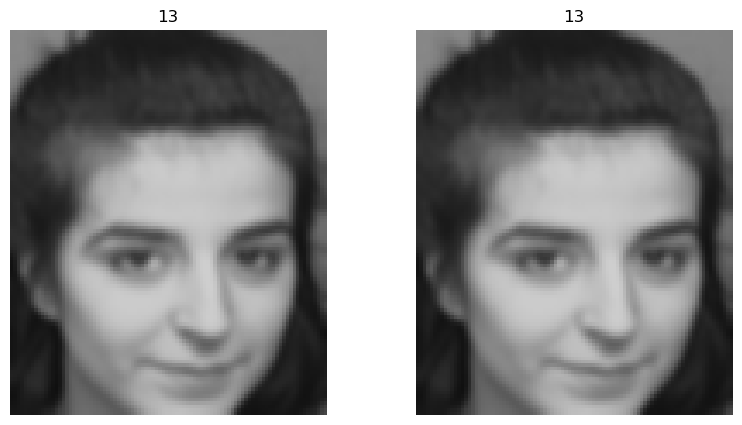

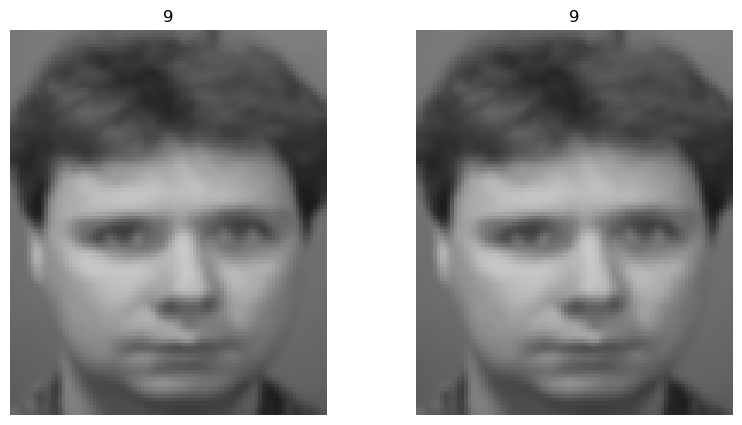

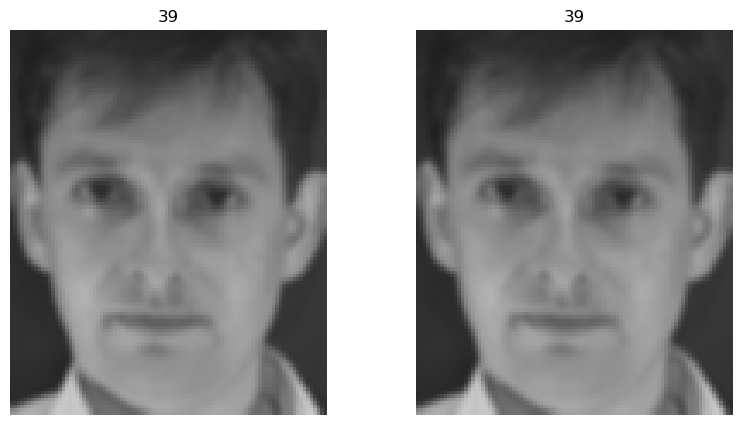

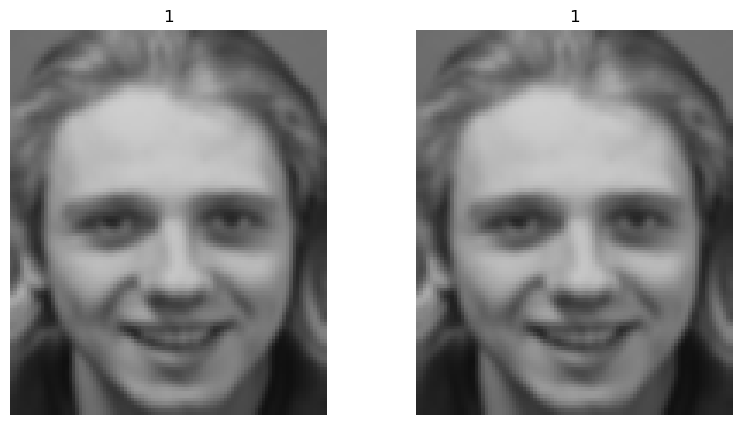

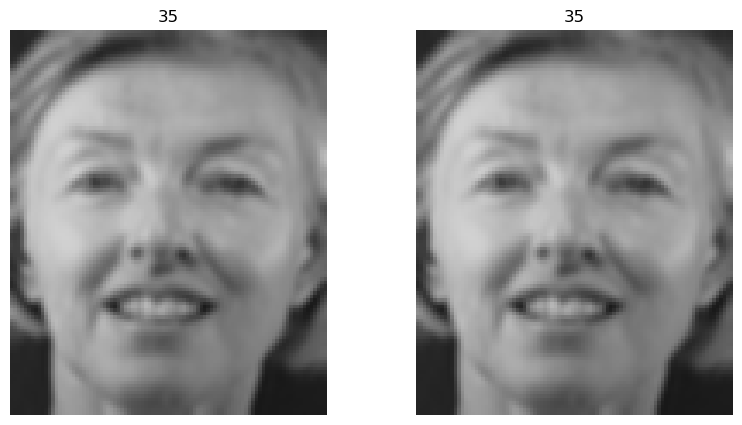

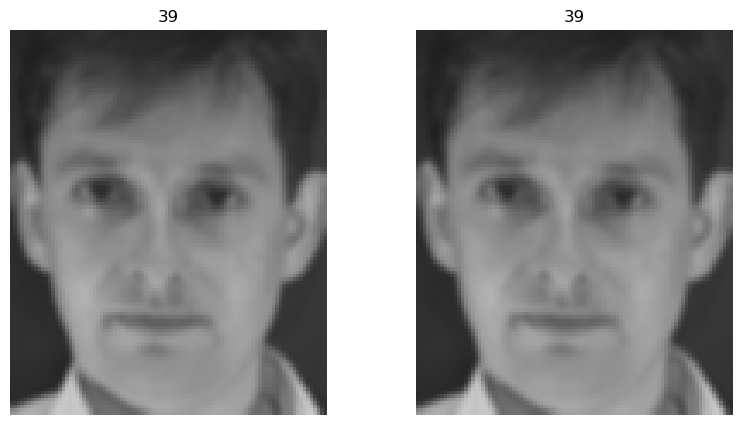

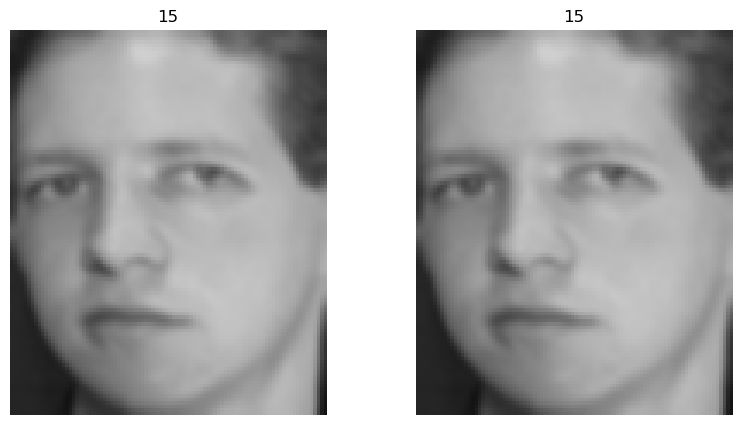

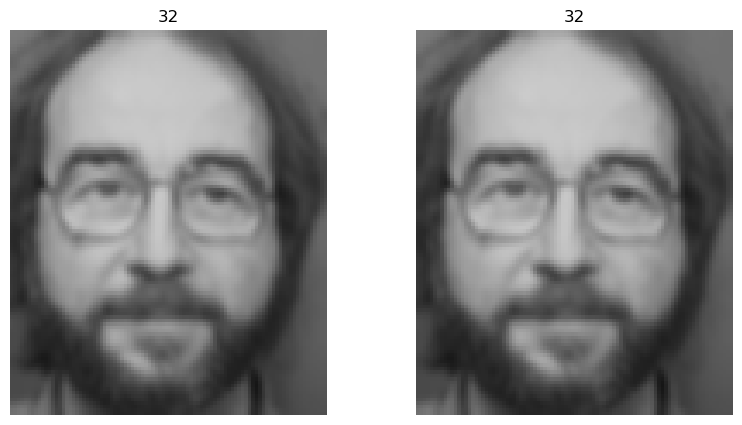

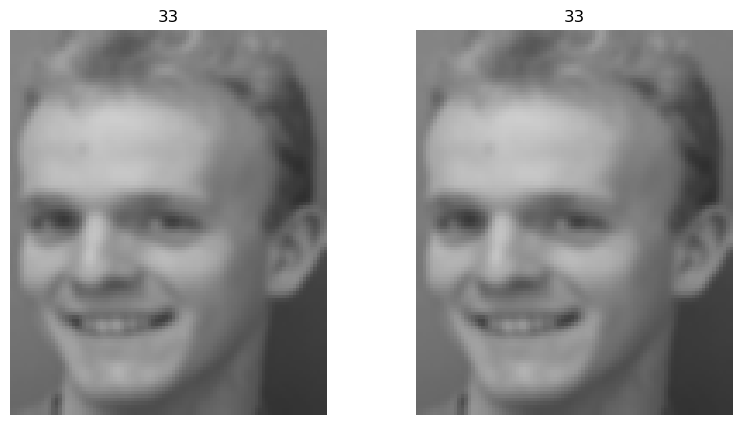

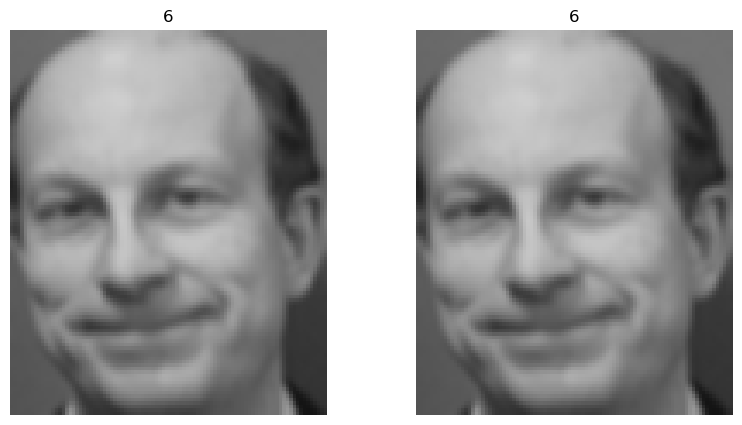

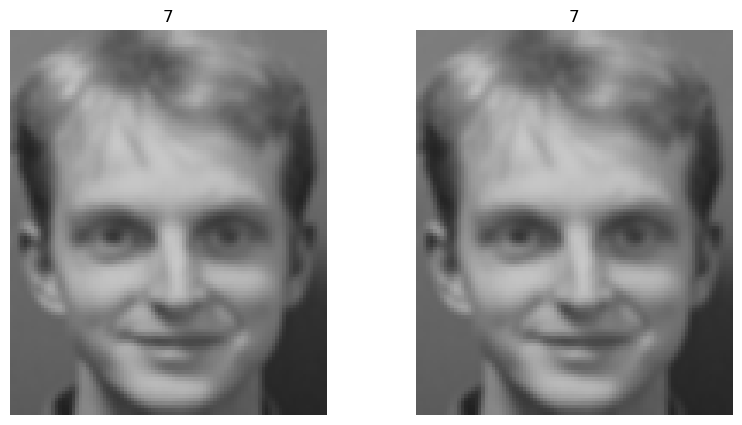

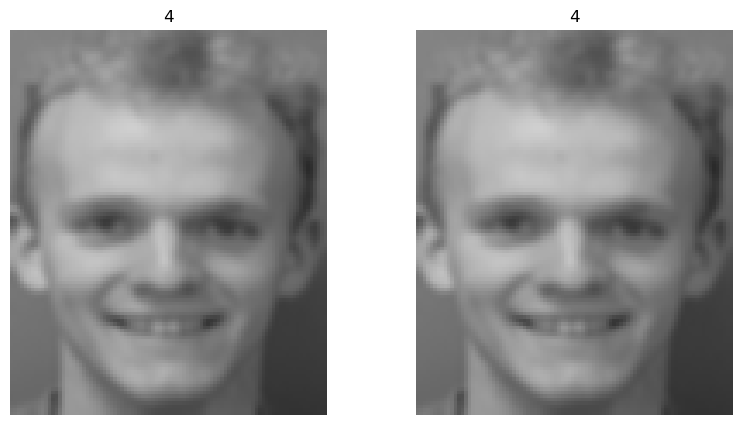

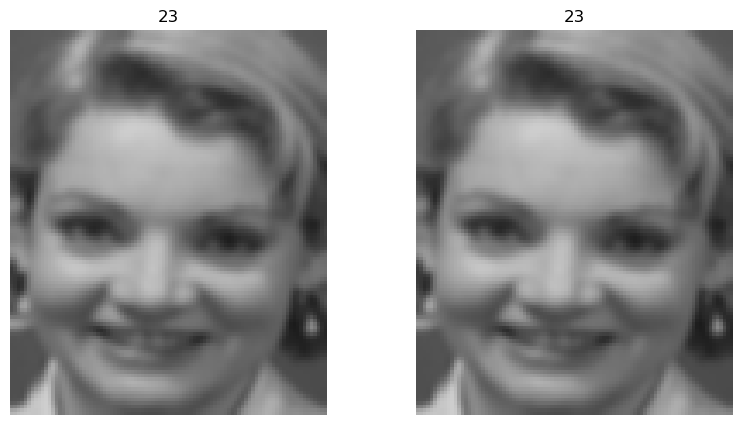

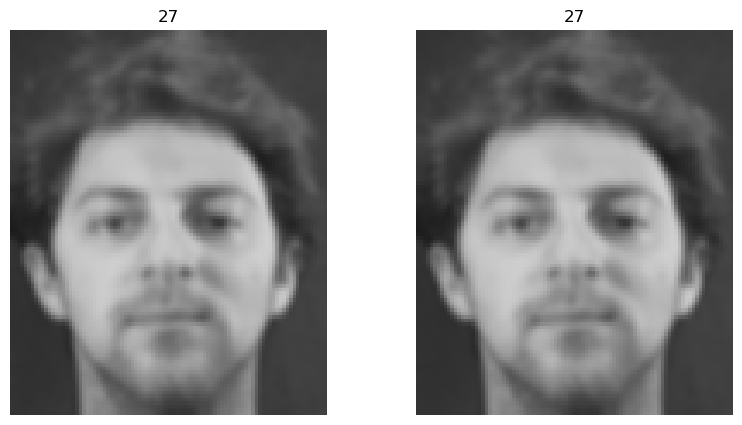

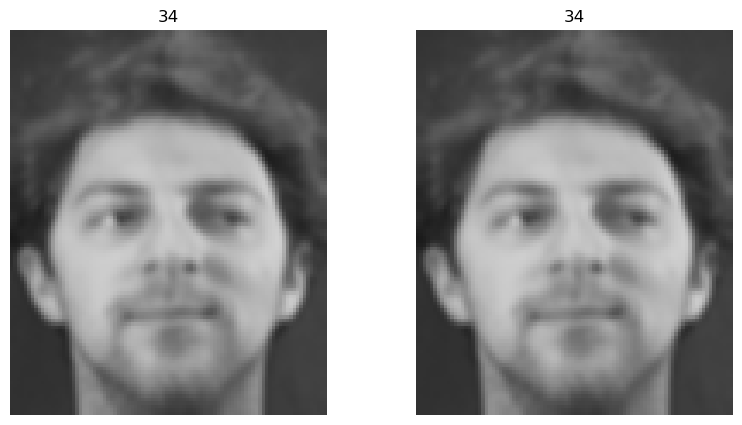

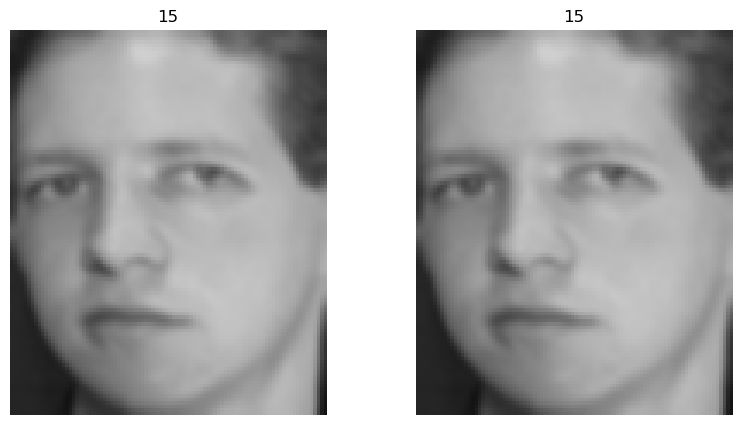

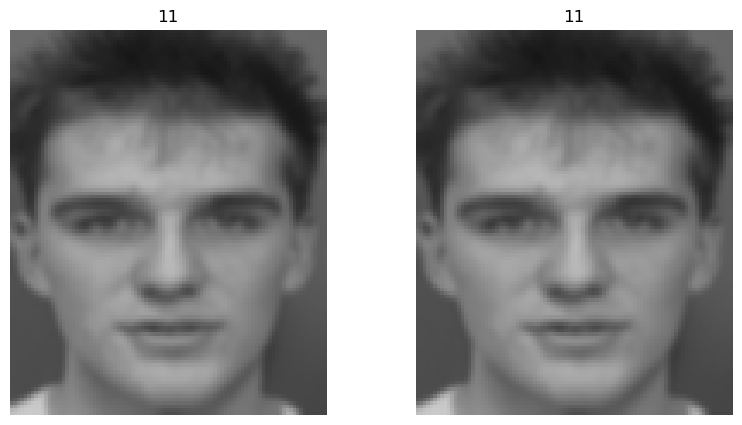

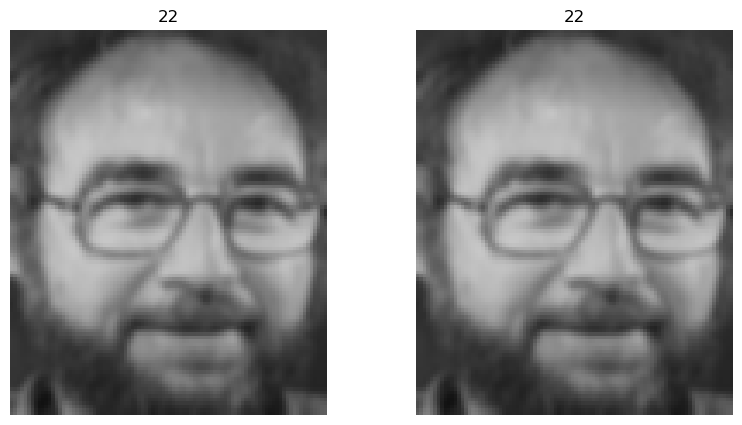

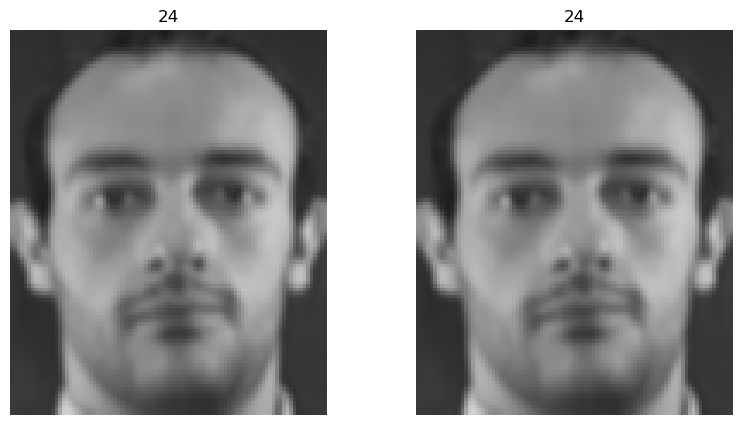

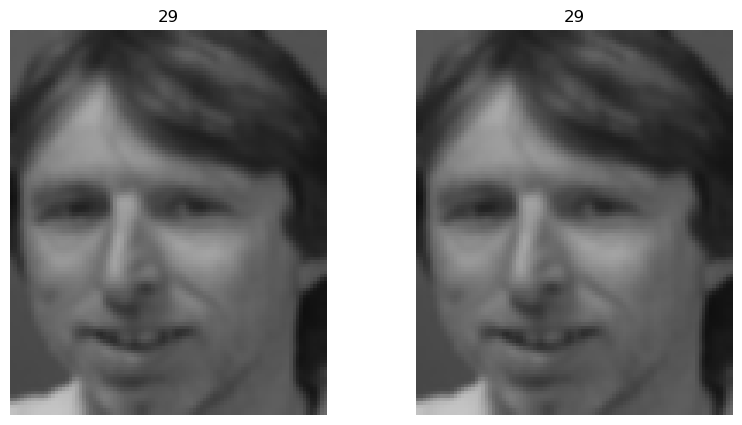

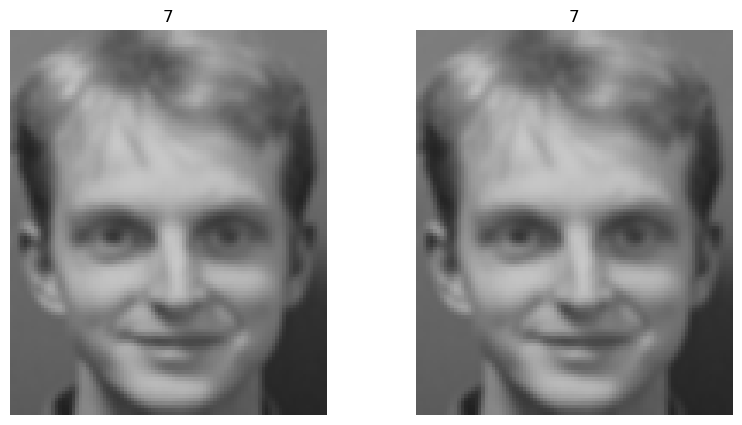

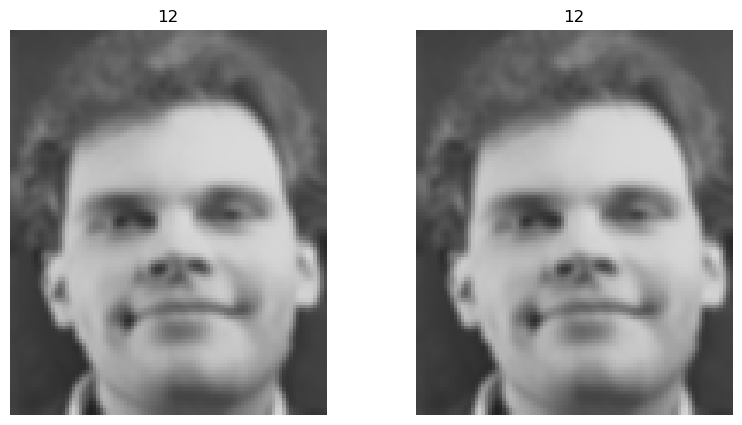

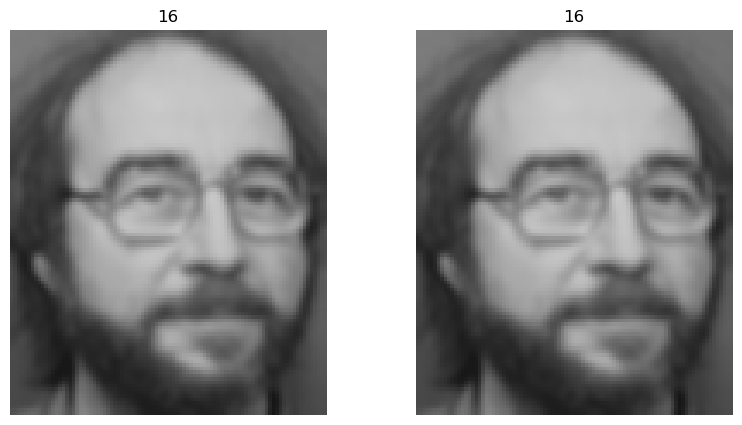

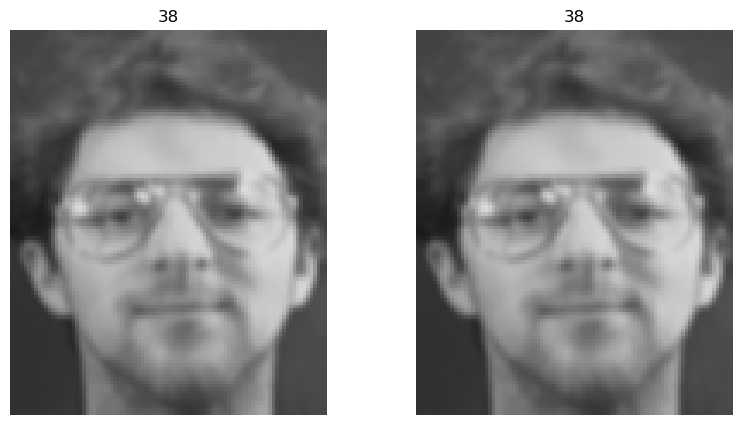

In [19]:
for i in range(len(Ytest)):
    if i%5==0:
        compare_images(y_pred[i],Ytest[i])

Text(0, 0.5, 'test_accuracies')

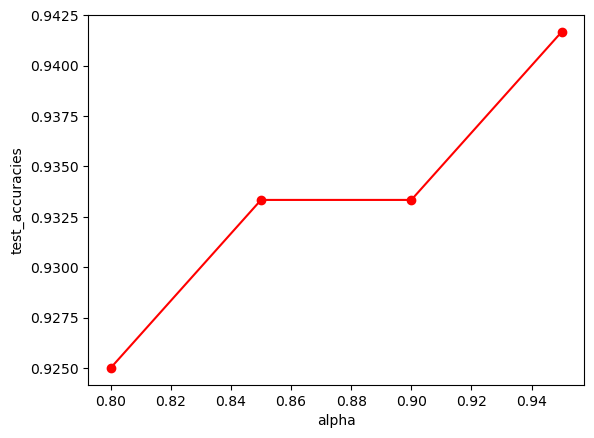

In [24]:
fig = plt.figure()
ax = plt.axes()

plt.plot(alphas, test_accuracies, linestyle='-', marker='o', color='red')
plt.xlabel("alpha")
plt.ylabel("test_accuracies")